<a href="https://colab.research.google.com/github/fazaghifari/BayesianOptTools/blob/newver/Kriging_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kriging (Gaussian Process) Demo
First, let's clone KADAL from Github Repo

In [0]:
# There will be some errors in the installation, just ignore it.
!pip install git+https://github.com/flowdiagnosticsitb/KADAL.git

  Cloning https://github.com/flowdiagnosticsitb/KADAL.git to /tmp/pip-req-build-2eskf40h
  Running command git clone -q https://github.com/flowdiagnosticsitb/KADAL.git /tmp/pip-req-build-2eskf40h
     |████████████████████████████████| 204kB 2.8MB/s 
     |████████████████████████████████| 686kB 8.8MB/s 
     |████████████████████████████████| 204kB 10.1MB/s 
     |████████████████████████████████| 419kB 14.5MB/s 
  Created wheel for kadal: filename=kadal-1.0.2-cp36-none-any.whl size=75651 sha256=2a1a92e6464902c752f0870d68eab78a6aedca508f5f3a284e98a68699cb1fdd
  Stored in directory: /tmp/pip-ephem-wheel-cache-l5jpb3d2/wheels/3c/fd/38/70e82ea24ca6ec25615628dafcc6174b1ba9f859aa5e3f237b
  Created wheel for configobj: filename=configobj-5.0.6-cp36-none-any.whl size=34546 sha256=475843eb2e322fd3878487d7882fe9fe5dcd7c565fadf5957d91f67e6f66644f
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built kadal configobj
ERROR: c

In [0]:
# Apparently because the error, cma is not installed.
!pip install cma

     |████████████████████████████████| 235kB 2.9MB/s 


### Import from kadal

In [0]:
from kadal.surrogate_models.kriging_model import Kriging
from kadal.misc.sampling.samplingplan import sampling
from kadal.testcase.analyticalfcn.cases import evaluate
from kadal.surrogate_models.supports.initinfo import initkriginfo
from kadal.surrogate_models.supports.errperf import errperf
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

### Create Kriging Function
Now, let's create a function that handle Kriging training process. In this demo we will use Styblinski-Tang fucntion with 40 samples as a test case.

In [0]:
def construct_krig():
    nsample = 50
    nvar = 2
    ub = np.array([5, 5])  # Define upper bound for the problem
    lb = np.array([-5, -5])  # Define lower bound for the problem

    # Now generate the sample points using "sampling" function
    # In this case we use Halton sampling
    # We also want to return "real" value of the sampling point, instead of
    # the normalized samples, hence we include result = 'real in the argument 
    samplenorm, X = sampling("halton", nvar, nsample, result='real',
                                  upbound=ub, lobound=lb)
    
    # Then, the samples are evaluated. In this case we use the built-in test 
    # case in KADAL.
    y = evaluate(X, 'styblinski')

    # Kriging in KADAL use a dictionary as its main information container
    # To initialize the dictionary:
    KrigInfo = initkriginfo()
    # Set KrigInfo
    KrigInfo['X'] = X  # KrigInfo['X'] and ['y'] is mandatory
    KrigInfo['y'] = y  
    KrigInfo['nrestart'] = 5  # Set the number of restarting points for hyperparameter optimization
    KrigInfo['ub'] = ub  # Set the upper bound of the problem, if empty maximum value of the sample is taken
    KrigInfo['lb'] = lb  # Same with ub
    KrigInfo["kernel"] = ["gaussian"]  # We support multi-kernel, e.g ["gaussian", "matern32"]
    KrigInfo["optimizer"] = "lbfgsb" # Use L-BFGS-B as the hyperparam optimizer

    # Construct Kriging
    t = time.time()
    # Now, initialize the Kriging object. Set the sample standardization into True
    # But, we don't want to normalize the response (normy = False)
    # We also don't want to train the Kriging variance ('trainvar = False')
    krigobj = Kriging(KrigInfo, standardization=True)
    # Train Kriging
    krigobj.train()
    # Calculate the leave-one-out cross validation (optional)
    loocverr,_ = krigobj.loocvcalc(metrictype='rmse')
    elapsed = time.time() - t
    print("elapsed time for train Kriging model: ", elapsed, "s")
    print("LOOCV error of Kriging model: ", loocverr, "%")

    return krigobj


### Create Predictor Function

Because we aim to construct a surface plot, most of the function is for plotting

In [0]:
def predictkrig(krigobj):
    neval = 10000  # Number of evaluation points

    # Create a linspace from -5 to 5
    xx = np.linspace(-5, 5, 100)
    yy = np.linspace(-5, 5, 100)
    # Create meshgrid from linspace
    Xevalx, Xevaly = np.meshgrid(xx, yy)
    # Reshape meshgrid to be feeded into Kriging predictor
    Xeval = np.zeros(shape=[neval, 2])
    Xeval[:, 0] = np.reshape(Xevalx, (neval))
    Xeval[:, 1] = np.reshape(Xevaly, (neval))

    # Predict the evaluation points
    yeval = krigobj.predict(Xeval,['pred'])  # For predicting uncertainty use ['pred','SSqr']
    # Calculate the real value of evaluation points
    yact = evaluate(Xeval, 'styblinski')

    # Evaluate the prediction error
    print('RMSE = ', errperf(yact, yeval, type='rmse'))
    print('MARE = ', errperf(yact, yeval, type='mare'))

    # Plot the result
    yeval1 = np.reshape(yeval, (100, 100))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xx, yy, yeval1, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Run

Begin train hyperparam.
Training 5 hyperparameter(s)
Training hyperparameter candidate no.1
Training hyperparameter candidate no.2
Training hyperparameter candidate no.3
Training hyperparameter candidate no.4
Training hyperparameter candidate no.5
Single Objective, train hyperparam, end.
Best hyperparameter is [-0.06768278 -0.06558988]
With NegLnLikelihood of 121.47648552358743
elapsed time for train Kriging model:  0.689805269241333 s
LOOCV error of Kriging model:  4.379695408530209 %
RMSE =  4.298317119160842
MARE =  0.0839388665050117


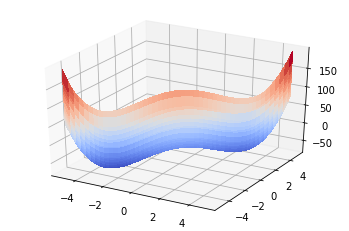

In [0]:
krigingobj1 = construct_krig()
predictkrig(krigingobj1)